In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import sklearn
warnings.filterwarnings("ignore")


In [13]:
train_cv = pd.read_csv('train_adc/train.csv')
items = pd.read_csv('train_adc/item_data.csv')
view_logs = pd.read_csv('train_adc/view_log.csv')

print(train_cv.columns.tolist(),items.columns.tolist(),view_logs.columns.tolist())

['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version', 'is_4G', 'is_click'] ['item_id', 'item_price', 'category_1', 'category_2', 'category_3', 'product_type'] ['server_time', 'device_type', 'session_id', 'user_id', 'item_id']


In [14]:
# Check data types and missing values
for name, df in zip(['Train', 'Items', 'View Logs'], [train_cv, items, view_logs]):
    print(f"\n{name} Info:")
    display(df.info())
    print(f"\n{name} Nulls:\n{df.isnull().sum()}")


Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   impression_id    237609 non-null  object
 1   impression_time  237609 non-null  object
 2   user_id          237609 non-null  int64 
 3   app_code         237609 non-null  int64 
 4   os_version       237609 non-null  object
 5   is_4G            237609 non-null  int64 
 6   is_click         237609 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 12.7+ MB


None


Train Nulls:
impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64

Items Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132761 entries, 0 to 132760
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   item_id       132761 non-null  int64
 1   item_price    132761 non-null  int64
 2   category_1    132761 non-null  int64
 3   category_2    132761 non-null  int64
 4   category_3    132761 non-null  int64
 5   product_type  132761 non-null  int64
dtypes: int64(6)
memory usage: 6.1 MB


None


Items Nulls:
item_id         0
item_price      0
category_1      0
category_2      0
category_3      0
product_type    0
dtype: int64

View Logs Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118622 entries, 0 to 3118621
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   server_time  object
 1   device_type  object
 2   session_id   int64 
 3   user_id      int64 
 4   item_id      int64 
dtypes: int64(3), object(2)
memory usage: 119.0+ MB


None


View Logs Nulls:
server_time    0
device_type    0
session_id     0
user_id        0
item_id        0
dtype: int64


In [15]:
train_cv['impression_time'] = pd.to_datetime(train_cv['impression_time'])
view_logs['server_time'] = pd.to_datetime(view_logs['server_time'])

In [16]:
# Merge view_logs with item data to enrich view log information
view_logs = view_logs.merge(items, on='item_id', how='left')

In [17]:
# Create user-level aggregated features from view logs
user_view_agg = view_logs.groupby('user_id').agg({
    'item_id': 'count',
    'item_price': ['mean', 'max'],
    'category_1': 'nunique',
    'category_2': 'nunique',
    'category_3': 'nunique',
    'product_type': 'nunique',
    'device_type': pd.Series.mode,  # Most common device

}).reset_index()

user_view_agg.columns = ['user_id', 'total_views', 'avg_item_price', 'max_item_price',
                         'unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types','device_type']

user_view_agg

,user_id,total_views,avg_item_price,max_item_price,unique_cat1,unique_cat2,unique_cat3,unique_product_types,device_type
0,0,42,9395.666667,92160.0,9,15,16,18,android
1,1,8,3946.750000,12595.0,7,7,7,8,android
2,2,165,14809.509091,281536.0,15,47,82,126,android
3,3,8,7257.375000,16640.0,3,3,3,3,android
4,4,2,30114.500000,58252.0,2,2,2,2,android
...,...,...,...,...,...,...,...,...,...
89152,92582,11,4614.181818,16531.0,8,9,10,9,android
89153,92583,3,46315.000000,74944.0,2,2,2,3,android
89154,92584,3,1601.000000,1601.0,1,1,1,1,android
89155,92585,5,11696.600000,30272.0,4,4,4,4,android


In [18]:
train_cv = train_cv.merge(user_view_agg, on='user_id', how='left')

In [19]:
train_cv.fillna({
    'total_views': 0,
    'avg_item_price': train_cv['avg_item_price'].median(),
    'max_item_price': train_cv['max_item_price'].median(),
    'unique_cat1': 0,
    'unique_cat2': 0,
    'unique_cat3': 0,
    'unique_product_types': 0
}, inplace=True)

In [20]:
train_cv.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click', 'total_views', 'avg_item_price', 'max_item_price',
       'unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types',
       'device_type'],
      dtype='object')

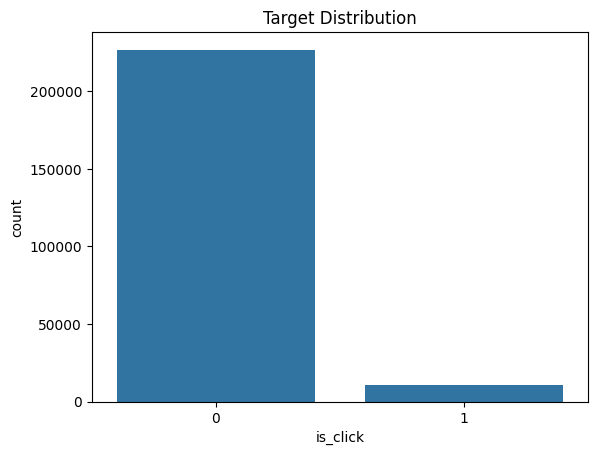

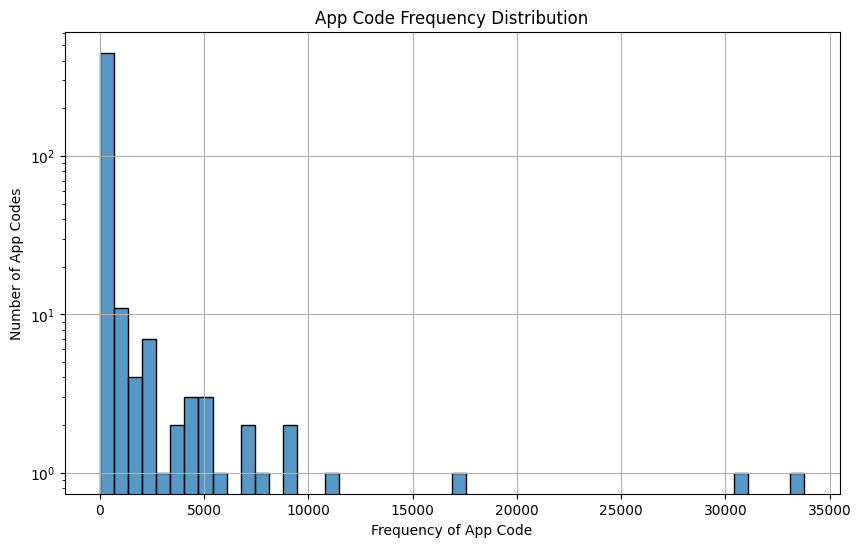

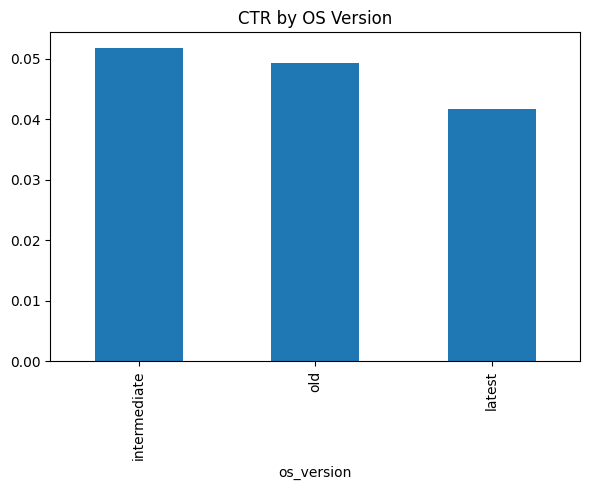

In [31]:
sns.countplot(data=train_cv, x='is_click')
plt.title('Target Distribution')

app_code_counts = train_cv['app_code'].value_counts()

# Plot the frequencies (log scale helps if highly skewed)
plt.figure(figsize=(10, 6))
sns.histplot(app_code_counts, bins=50, kde=False)
plt.title('App Code Frequency Distribution')
plt.xlabel('Frequency of App Code')
plt.ylabel('Number of App Codes')
plt.yscale('log')  # Optional: Log scale helps if data is very skewed
plt.grid(True)
plt.show()

# CTR by OS Version
plt.figure(figsize=(6, 5))
train_cv.groupby('os_version')['is_click'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('CTR by OS Version')
plt.tight_layout()

plt.show()

In [22]:
train['impression_time'] = pd.to_datetime(train['impression_time'])

train['hour'] = train['impression_time'].dt.hour
train['dayofweek'] = train['impression_time'].dt.dayofweek
train['is_weekend'] = train['dayofweek'].isin([5, 6]).astype(int)

In [23]:
# Label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['app_code'] = le.fit_transform(train['app_code'])
train['os_version'] = le.fit_transform(train['os_version'])


In [24]:
view_logs.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0


In [25]:
train = train.merge(user_view_agg, on='user_id', how='left')

In [26]:
app_code_counts = train['app_code'].value_counts()
rare_app_codes = app_code_counts[app_code_counts < 50].index
train['app_code_grouped'] = train['app_code'].apply(lambda x: 'other' if x in rare_app_codes else x)

In [27]:
for col in ['unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types']:
    train[col] = train[col].astype(str)  # If needed
    train[col] = le.fit_transform(train[col])


In [28]:
features = [
    'source', 'app_code', 'os_version',
    'hour', 'dayofweek', 'is_weekend',
    'item_price', 'category_1', 'category_2', 'category_3', 'product_type',
    'view_count', 'avg_item_price', 'max_item_price',
    'unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types'
]
target = 'is_click'


In [29]:
train.columns.tolist()

['impression_id',
 'impression_time',
 'user_id',
 'app_code',
 'os_version',
 'is_4G',
 'is_click',
 'hour',
 'dayofweek',
 'is_weekend',
 'total_views',
 'avg_item_price',
 'max_item_price',
 'unique_cat1',
 'unique_cat2',
 'unique_cat3',
 'unique_product_types',
 'device_type',
 'app_code_grouped']

In [30]:
train['source'] = le.fit_transform(train['source'])

KeyError: 'source'

In [ ]:
%pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.6 MB 2.0 MB/s eta 0:00:05
   ------- -------------------------------- 1.8/9.6 MB 3.1 MB/s eta 0:00:03
   --------- ------------------------------ 2.4/9.6 MB 3.0 MB/s eta 0:00:03
   ------------- -------------------------- 3.1/9.6 MB 3.2 MB/s eta 0:00:03
   ---------------- ----------------------- 3.9/9.6 MB 3.1 MB/s eta 0:00:02
   ------------------ --------------------- 4.5/9.6 MB 3.0 MB/s eta 0:00:02
   -------------------- ------------------- 5.0/9.6 MB 3.0 MB/s eta 0:00:02
   ------------------------ --------------- 5.8/9.6 MB 3.0 MB/s eta 0:00:02
   -------------------------- ------------- 6.3/9.6 MB 3.0 MB/s eta 0:00:02
   ----------------------------- ---------- 7.1/9.6 MB 3.0 MB/s eta 0:00:01
   ------------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
